In [11]:
import Zygote: @ignore_derivatives
import CSV
import Plots
import Random
import Optimisers
import Zygote
import GLM
using DataFrames
using Lux
using JLD2
using Statistics
using Printf
using DifferentialEquations
using StatsBase: sample


include("../../../DCM/src/lib/population.jl");
include("../../../DCM/src/lib/model.jl");
include("../../../DCM/src/lib/error.jl");
include("../../../DCM/src/lib/callbacks.jl");
include("../../../DCM/src/lib/nn.jl");
include("../../../DCM/src/lib/lux.helpers.jl");

## Data preparation

In [13]:
# Read Data
file = "../../data/fviii_sim.csv"
df = CSV.read(file, DataFrame)

# One dataframe per patient
df_group = groupby(df, :id);

In [14]:
# Create population
function create_population(df_group_inds)
    indvs = Vector{AbstractIndividual}(undef, length(df_group_inds))
    for (i, group) in enumerate(df_group_inds)
        x = Vector{Float32}(group[1, [:weight, :age, :amt]])
        ty = group[(group.mdv .== 0), [:t, :dv]]
        indvs[i] = Individual(x, Float32.(ty.t), Float32.(ty.dv), CallbackSet(); id = group.id[1])
    end
    return Population(indvs);
end

population = create_population(df_group);

## Training

### Functions

In [15]:
# Create neural network architecture
function dnn()
    return Chain(
            Normalize([70, 40, 70*25, 1]),
            Dense(4, 16, swish), 
            Dense(16, 4, swish), 
            Dense(4, 1, softplus)
        )
end

# Train
function train_model(model, population_train, num_epochs; population_test=nothing, verbose=true, patience=100, tol=0.001)
    global opt_state
    losses = []
    losses_test = []
    times = []

    count = 0
    for epoch in 1:num_epochs

        elapsed_time = @elapsed begin
            loss, back = Zygote.pullback(p -> objective(model, population_train, p), model.p);
            grad = first(back(1))
            opt_state, p = Optimisers.update(opt_state, model.p, grad)
            update!(model, p)
        end
        push!(times, elapsed_time)

        push!(losses, loss)
        if population_test !== nothing
            push!(losses_test, objective(model, population_test, model.p))
        end

        if (epoch == 1 || epoch % 100 == 0) && verbose
            println("Epoch $epoch, loss = $loss")
        end

        if epoch == 300      
            Optimisers.adjust!(opt_state, 0.001)
        end

        # Early stopping on percentual change of test loss. The test population is needed
        if population_test !== nothing
            if (epoch > 1) && ((losses_test[end-1] - losses_test[end])/losses_test[end-1] < tol)
                count += 1
                if count == patience
                    println("Early stopped. Percentual test loss did not improve at least $tol for $patience epochs. Trained for $epoch epochs\n")
                    return model, losses, losses_test
                end
            else 
                count = 0
            end
        end

    end
    verbose && println("\nMean ± std training time per epoch: $(@sprintf("%.2e", mean(times))) ± $(@sprintf("%.2e", std(times))) seconds")
    return model, losses, losses_test
end

# MAE
function mae(model, population)
    ŷ = predict(model, population)[1]
    dif = ŷ - reduce(vcat, population.y)
    return sum(abs, dif)/length(dif)
end

# Plot predictions vs real values
function plot_predictions_real(model, population; threshold=0.2)
    real = reduce(vcat, population.y)
    predicted = predict(model, population)[1]

    plt = Plots.scatter(
        real,
        predicted,
        xlabel="True",
        ylabel="Predicted",
        markersize=2,
        markercolor=:blue,
        size=(600,400),
        legend=false
    )

    lr = GLM.lm(GLM.@formula(y ~ X), DataFrame(X=Float64.(real), y=Float64.(predicted)))

    accuracy = count(x -> x < threshold, abs.((real - predicted)) ./ (real .+ 1e-6))/length(real)
    max_value = ceil(maximum(vcat(real, predicted)))
    Plots.plot!(plt, 
        [0, max_value], 
        [0, max_value],
        #ribbon = [0, max_value] .* threshold,
        fillalpha = 0.2,
        #color = "red",
        linestyle = :dash,
        
        )

    regression = GLM.predict(lr, DataFrame(X=[0, max_value]))
    rsquared = GLM.r2(lr)

    Plots.plot!(plt, 
        [0, max_value], 
        regression,
        color = "blue",
        title = "R2 = $(@sprintf("%.2f", rsquared))"
        )
    display(plt)
end

function training_metrics(model, population)
    #MAE
    mean_absolute_error = mae(model, population)

    #R2
    real = reduce(vcat, population.y)
    predicted = predict(model, population)[1]
    lr = GLM.lm(GLM.@formula(y ~ X), DataFrame(X=Float64.(real), y=Float64.(predicted)))
    rsquared = GLM.r2(lr)

    return mean_absolute_error, rsquared
end

# Plot predictions vs real values
function plot_train_test_real(model, population_train, population_test)
    real = reduce(vcat, population.y)
    predicted = predict(model, population)[1]

    plt = Plots.scatter(
        reduce(vcat, population_train.y),
        predict(model, population_train)[1],
        xlabel="True",
        ylabel="Predicted",
        markersize=2,
        markercolor=:blue,
        size=(600,400),
        label="Train"
    )

    Plots.scatter!(
        reduce(vcat, population_test.y),
        predict(model, population_test)[1],
        xlabel="True",
        ylabel="Predicted",
        markersize=2,
        markercolor=:red,
        size=(600,400),
        label="Test"
    )

    max_value = ceil(maximum(vcat(real, predicted)))
    Plots.plot!(plt, 
        [0, max_value], 
        [0, max_value],
        linestyle = :dash,
        color=:black,
        label=nothing
        )
    display(plt)
end

plot_train_test_real (generic function with 1 method)

### Train using all the population

Epoch 1, loss = 9062.91
Epoch 100, loss = 2826.8115
Epoch 200, loss = 1401.0175
Epoch 300, loss = 817.92065
Epoch 400, loss = 782.7128
Epoch 500, loss = 751.0971
Epoch 600, loss = 720.2045
Epoch 700, loss = 690.42993
Epoch 800, loss = 662.19653
Epoch 900, loss = 635.93506
Epoch 1000, loss = 612.0402

Mean ± std training time per epoch: 5.96e-04 ± 5.57e-04 seconds

Final MSE: 612.0402
Final MAE: 5.1956058
Final R2: 0.8818431782910618


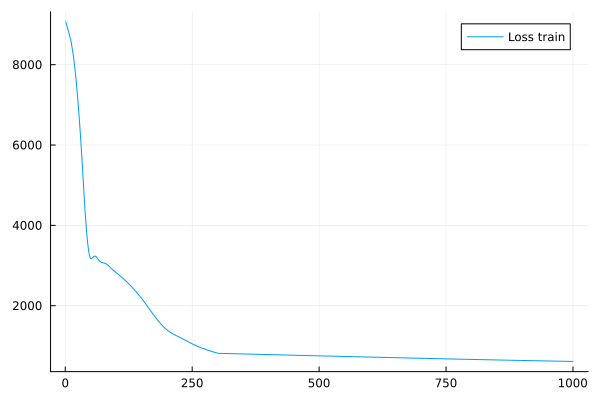

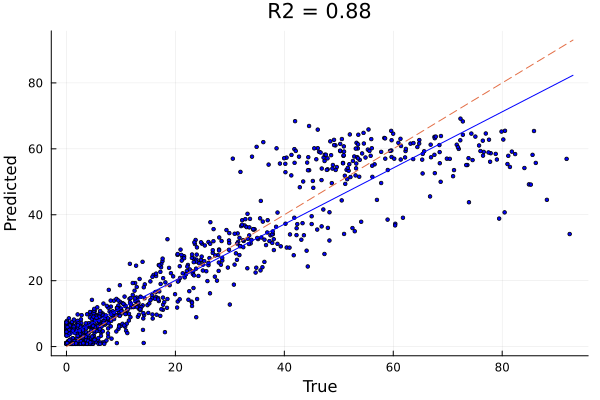

In [58]:
ann = dnn()
model = SNN(ann)
objective(model, population)

opt = Optimisers.ADAM(1e-2)
opt_state = Optimisers.setup(opt, model.p);

model, losses, _ = train_model(model, population, 1_000; population_test = nothing)

println()
final_mse = losses[end]
println("Final MSE: $final_mse")

final_mae, final_r2 = training_metrics(model, population)

println("Final MAE: $final_mae")
println("Final R2: $final_r2")

plt = Plots.plot(losses, label = "Loss train")
display(plt)

plot_predictions_real(model, population)

### Save/load model

In [59]:
# Save model
#jldsave("models/mymodel-fviii-5.jld2"; model)

In [9]:
# Load model
#mymodel = JLD2.load("models/mymodel-fviii.jld2")
#model = mymodel["model"]

StandardNeuralNetwork{SSE}

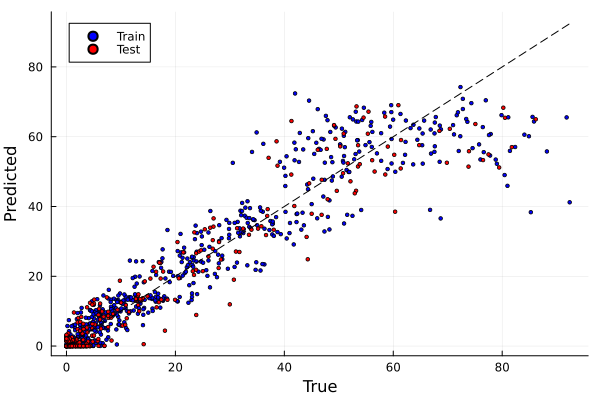

In [10]:
plot_train_test_real(model, population_train, population_test)

### Train using test split

Epoch 1, loss = 9408.971
Epoch 100, loss = 2877.441
Epoch 200, loss = 1965.423
Epoch 300, loss = 876.7375
Epoch 400, loss = 835.8276
Epoch 500, loss = 802.9853
Epoch 600, loss = 773.44775
Epoch 700, loss = 747.13684
Epoch 800, loss = 721.1983
Epoch 900, loss = 692.9345
Epoch 1000, loss = 670.9906

Mean ± std training time per epoch: 2.18e-02 ± 6.49e-01 seconds


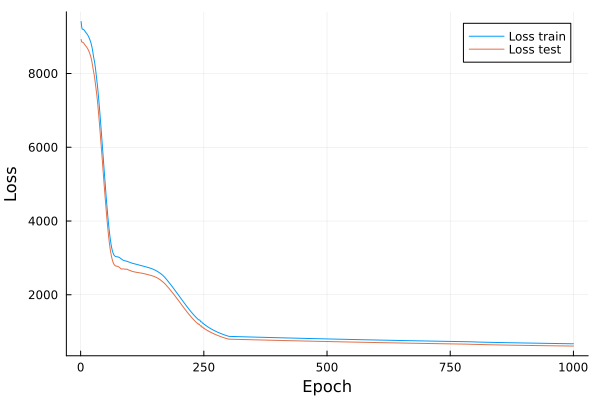


Final MAE train: 5.751711
Final R2 train: 0.8719425029135892

Final MAE test: 5.5557866
Final R2 test: 0.8798280834424644


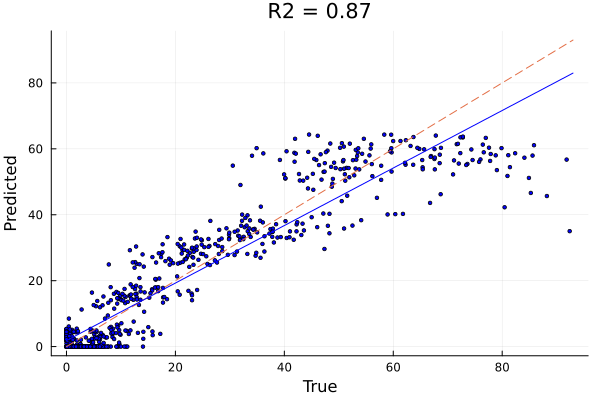

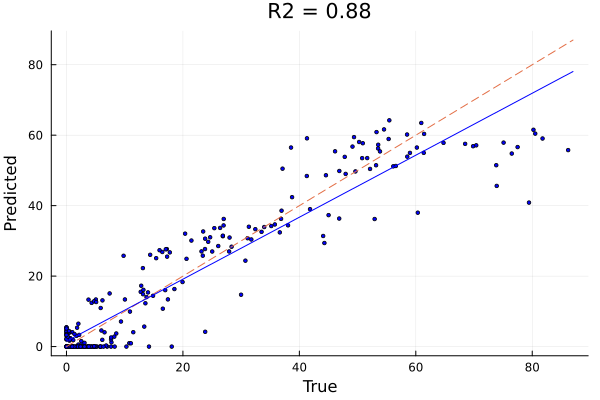

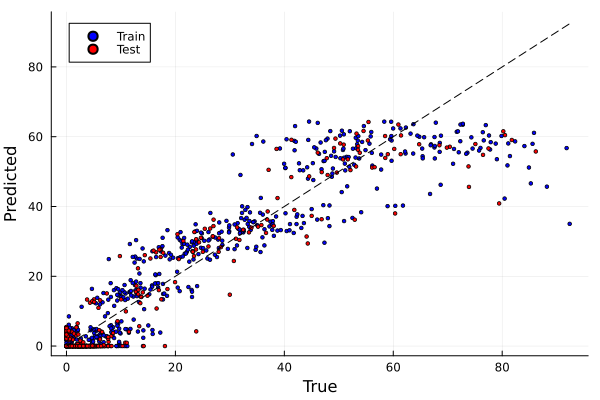

In [8]:
# Get random patients for train and test
Random.seed!(123)
ids = 1:length(df_group)
test_ids = sample(ids, div(length(ids), 4), replace = false)
train_ids = setdiff(ids, test_ids)

# Create train and test populations
population_test = create_population(df_group[test_ids]);
population_train = create_population(df_group[train_ids]);

ann = dnn()
model = SNN(ann)

opt = Optimisers.ADAM(1e-2)
opt_state = Optimisers.setup(opt, model.p);

model, losses, losses_test = train_model(model, population_train, 1_000; population_test = population_test, patience=100, tol=0.0001)

plt = Plots.plot(losses, label = "Loss train", xlabel="Epoch", ylabel="Loss")
Plots.plot!(plt, losses_test, label = "Loss test")
display(plt)

println()
final_mae_train, final_r2_train = training_metrics(model, population_train)
println("Final MAE train: $final_mae_train")
println("Final R2 train: $final_r2_train")
println()
final_mae_test, final_r2_test = training_metrics(model, population_test)
println("Final MAE test: $final_mae_test")
println("Final R2 test: $final_r2_test")

plot_predictions_real(model, population_train)
plot_predictions_real(model, population_test)

plot_train_test_real(model, population_train, population_test)

### K folds training

In [236]:
# Get random patients for train and test
folds = 7
ids = 1:length(df_group)

l_mae_train = []
l_mae_test = []
l_r2_train = []
l_r2_test = []

for i in 1:folds
    println("Fold $i/$folds")
    test_ids = sample(ids, div(length(ids), 4), replace = false)
    train_ids = setdiff(ids, test_ids)

    # Create train and test populations
    population_test = create_population(df_group[test_ids]);
    population_train = create_population(df_group[train_ids]);

    ann = dnn()
    model = SNN(ann)

    opt = Optimisers.ADAM(1e-2)
    opt_state = Optimisers.setup(opt, model.p);

    model, _, _ = train_model(model, population_train, 1000; population_test = population_test, verbose=false, patience=100, tol=0.0001)

    final_mae_train, final_r2_train = training_metrics(model, population_train)
    push!(l_mae_train, final_mae_train)
    push!(l_r2_train, final_r2_train)

    final_mae_test, final_r2_test = training_metrics(model, population_test)
    push!(l_mae_test, final_mae_test)
    push!(l_r2_test, final_r2_test)
end

# Remove largest and smallest values from list. To remove extreme cases that can happen due to initialization
l_mae_train = filter(x -> x != maximum(l_mae_train) && x != minimum(l_mae_train), l_mae_train)
l_mae_test = filter(x -> x != maximum(l_mae_test) && x != minimum(l_mae_test), l_mae_test)
l_r2_train = filter(x -> x != maximum(l_r2_train) && x != minimum(l_r2_train), l_r2_train)
l_r2_test = filter(x -> x != maximum(l_r2_test) && x != minimum(l_r2_test), l_r2_test)

println()
println("Mean ± std MAE train: $(@sprintf("%.2f", mean(l_mae_train))) ± $(@sprintf("%.2f", std(l_mae_train)))")
println("Mean ± std MAE test: $(@sprintf("%.2f", mean(l_mae_test))) ± $(@sprintf("%.2f", std(l_mae_test)))")
println()
println("Mean ± std R2 train: $(@sprintf("%.2f", mean(l_r2_train))) ± $(@sprintf("%.2f", std(l_r2_train)))")
println("Mean ± std R2 test: $(@sprintf("%.2f", mean(l_r2_test))) ± $(@sprintf("%.2f", std(l_r2_test)))")

Fold 1/7
Fold 2/7
Fold 3/7
Early stopped. Percentual test loss did not improve at least 0.0001 for 100 epochs. Trained for 948 epochs

Fold 4/7
Early stopped. Percentual test loss did not improve at least 0.0001 for 100 epochs. Trained for 465 epochs

Fold 5/7
Early stopped. Percentual test loss did not improve at least 0.0001 for 100 epochs. Trained for 745 epochs

Fold 6/7
Fold 7/7
Early stopped. Percentual test loss did not improve at least 0.0001 for 100 epochs. Trained for 477 epochs


Mean ± std MAE train: 4.99 ± 0.19
Mean ± std MAE test: 5.18 ± 0.33

Mean ± std R2 train: 0.89 ± 0.01
Mean ± std R2 test: 0.89 ± 0.02


### Train for just a few epochs

Epoch 1, loss = 9114.287
Epoch 100, loss = 2527.2627
Epoch 200, loss = 769.73553

Mean ± std training time per epoch: 1.58e-03 ± 2.37e-03 seconds
Final MAE: 6.0422125
Final R2: 0.8526854415589771


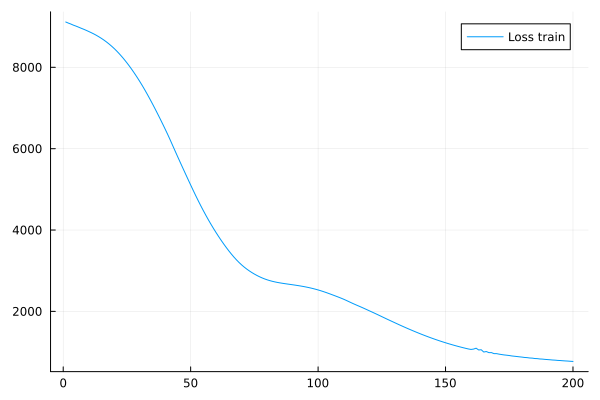

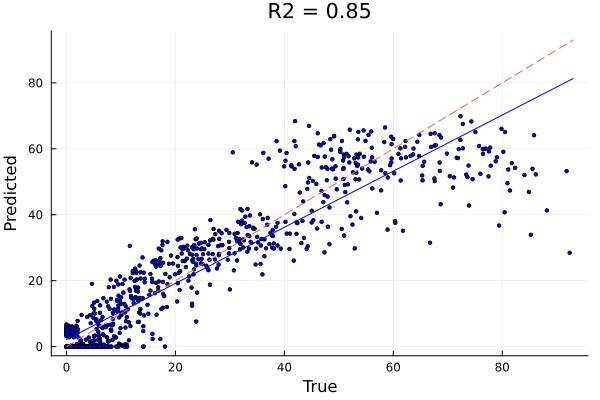

In [237]:
ann = dnn()
model = SNN(ann)

opt = Optimisers.ADAM(1e-2)
opt_state = Optimisers.setup(opt, model.p);

model, losses, _ = train_model(model, population, 200; population_test = nothing)

final_mae, final_r2 = training_metrics(model, population)

println("Final MAE: $final_mae")
println("Final R2: $final_r2")

plt = Plots.plot(losses, label = "Loss train")
display(plt)

plot_predictions_real(model, population)


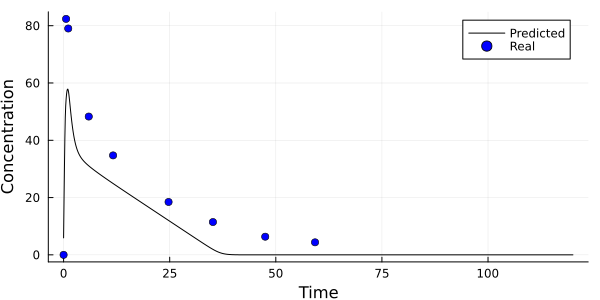

In [238]:
predict_real_individual(population[10], model; max_time = 120, plot_predictions = true, plot_true_labels = true);
#Plots.savefig("./results/10p_epochs.png")


## Predict

### Functions

In [17]:
# Predict a single individual. The predicted values are only saved for the individual.t times
function predict_individual(individual, model; plot_predictions=false)

    predicted = predict(model, individual)[1]

    if plot_predictions
        plt = Plots.plot(individual.t, predicted, 
                    label="Predicted", xlabel="Time", ylabel="Concentration",
                    color = :black,
                    size=(600,300))
        display(plt)
    end

    return predicted
end


# Predict a single real individual with labels. The predicted values are saved for all the times between 0 and max_time but the real labels are plotted for the real times
function predict_real_individual(individual, model; max_time = 120, plot_predictions = false, plot_true_labels = false)

    time_real = individual.t
    real_y = individual.y

    time = collect(0:0.1:(max_time))
    subject = Individual(individual.x, Float32.(time), Float32.(zeros(length(time))), individual.callback)

    predicted = predict(model, subject)[1]

    if plot_predictions
        plt = Plots.plot(subject.t, predicted, 
                    label="Predicted", xlabel="Time", ylabel="Concentration",
                    color = :black,
                    size=(600,300))
        if plot_true_labels
            Plots.scatter!(plt, time_real, real_y, label="Real", color=:blue)
        end
        display(plt)
    end
    return predicted, time
end

predict_real_individual (generic function with 1 method)

### Predict real individual from population with real labels

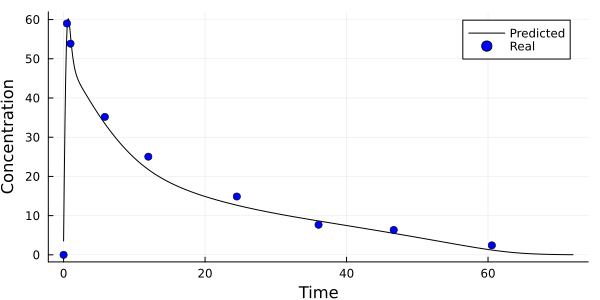

In [50]:
predict_real_individual(population[1], model; max_time = 72, plot_predictions = true, plot_true_labels = true);
# Plots.savefig("./results/discontinuity.png")

#predict_real_individual(population[8], model; max_time = 120, plot_predictions = true, plot_true_labels = true);
#Plots.savefig("./results/fit_large_values.png");

### Predict single individual without labels

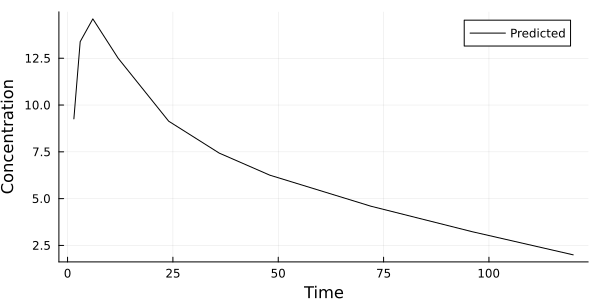

In [16]:
t = collect(0:1:200)
x = [50.0, 27.0, 0, 100.0]
subject = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), CallbackSet())

subject = population[10];

predict_individual(subject, model; plot_predictions=true);

## Experiments

### Functions

In [17]:
function test_variables(ind, model; variable="AMT", values=[0, 1, 10, 50, 100, 200, 500])
    colors = Plots.palette(:rainbow, length(values))

    cback = ind.callback
    x = copy(ind.x)
    t = copy(ind.t)

    plt = Plots.plot(label="Predicted", xlabel="Time", ylabel="Concentration", size=(600,300))
    for (i, val) in enumerate(values)
        if variable == "AMT"
            x[4] = val
        elseif variable == "WEIGHT"
            x[1] = val
        elseif variable == "AGE"
            x[2] = val
        elseif variable == "SEX"
            x[3] = val
        else
            error("Variable not found")
        end

        test_ind = Individual(Float32.(x), Float32.(ind.t), Float32.(zeros(length(t))), cback)

        predicted = predict_individual(test_ind, model; plot_predictions=false);
        Plots.plot!(test_ind.t, predicted, linewidth=1, label="$variable=$val", linecolor=colors[i])
    end
    display(plt)
end

test_variables (generic function with 1 method)

### Initialize individual

In [18]:
t = collect(0:0.1:120)
x = [70.0, 40.0, 0, 100.0]
subject = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), CallbackSet());

### Change AMT

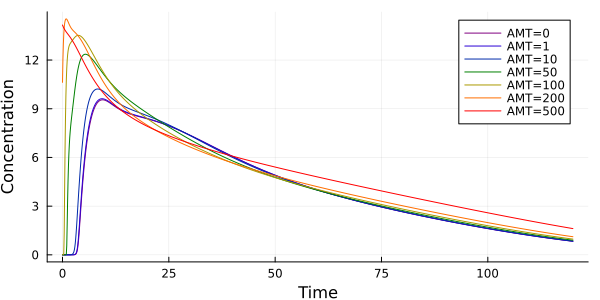

In [19]:
test_variables(subject, model; variable="AMT", values=[0, 1, 10, 50, 100, 200, 500]);
# Plots.savefig("./results/amt.png")

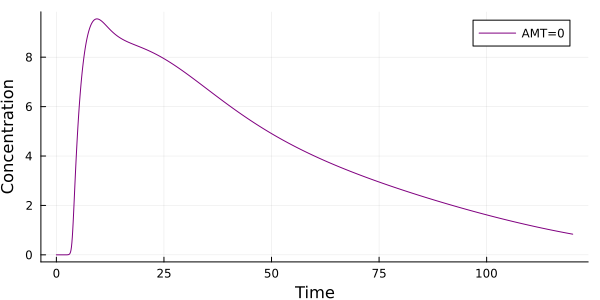

"/Users/rafaelcuperman/Dropbox/Models/neural_network_comparison/models/DNN/results/amt0.png"

In [316]:
test_variables(subject, model; variable="AMT", values=[0]);
# Plots.savefig("./results/amt0.png")

### Change Weight

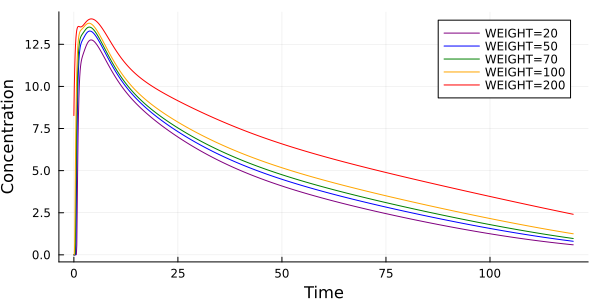

In [20]:
test_variables(subject, model; variable="WEIGHT", values=[20, 50, 70, 100, 200])
# Plots.savefig("./results/weight.png")

### Change Age

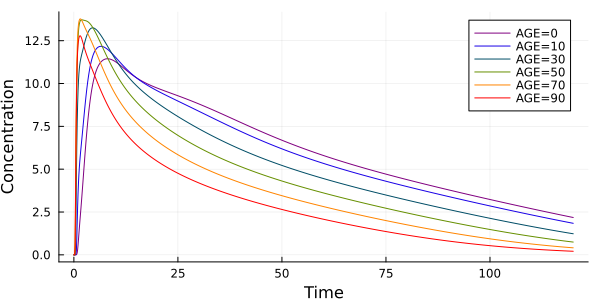

"/Users/rafaelcuperman/Dropbox/Models/neural_network_comparison/models/DNN/results/age.png"

In [318]:
test_variables(subject, model; variable="AGE", values=[0, 10, 30, 50, 70, 90])
# Plots.savefig("./results/age.png")

### Change Sex

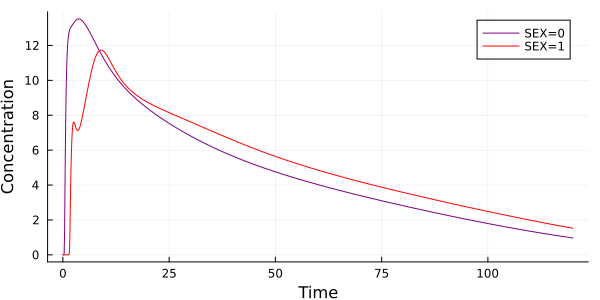

"/Users/rafaelcuperman/Dropbox/Models/neural_network_comparison/models/DNN/results/sex.png"

In [319]:
test_variables(subject, model; variable="SEX", values=[0, 1])
# Plots.savefig("./results/sex.png")

### Simulate long time

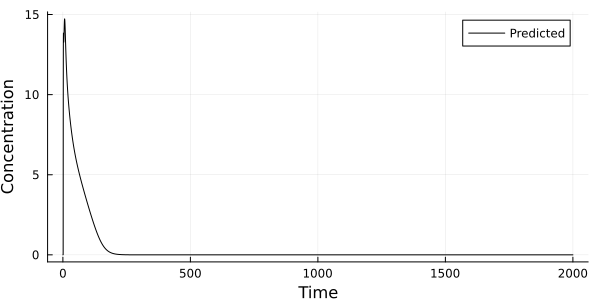

In [21]:
t = collect(0:0.1:2000)
x = [70.0, 40.0, 0, 100.0]

subject = population[10];
x = copy(subject.x)
subject = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), CallbackSet());

predict_individual(subject, model; plot_predictions=true);
#Plots.savefig("./results/long_time.png")